In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./graphs

%tensorflow_version 2.x

!apt-get update -y
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt install xvfb

!dpkg --configure -a
!pip install tqdm
!pip install box2d  
!pip install -q tf-agents

#http://fnl.es/a-quick-reference-for-working-with-tensorflow.html

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape, Conv2D,Flatten
from tensorflow.keras.optimizers import Adam
import random
import tqdm
import pandas as pd

tf.disable_eager_execution()
from google.colab import drive
drive.mount('/content/drive')
import math
import time

from tf_agents.utils import  value_ops

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from gym.spaces.box import Box
from gym.core import Wrapper

import cv2
class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        img = img[34:-16, :, :]
        img = cv2.resize(img, self.img_size)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.mean(-1, keepdims=True)
        img = img.astype('float32')/255.0
        
        return img.reshape(self.img_size + (1,))

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4):
        super(FrameBuffer, self).__init__(env)
    
        height, width, n_channels = env.observation_space.shape
        obs_shape = [height, width, n_channels * n_frames]
       
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        img = self.env.reset()
        self.update_buffer(img)

        """print("Reset framebuffer")
        plt.figure()
        plt.imshow(img[:,:,0])
        plt.figure()
        plt.imshow(self.framebuffer)"""

        return self.framebuffer

    def step(self, action):
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)

        """print("step framebuffer")
        plt.figure()
        plt.imshow(new_img[:,:,0])
        plt.figure()
        plt.imshow(self.framebuffer)"""

        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        offset = self.env.observation_space.shape[-1]
        axis = -1
        cropped_framebuffer = self.framebuffer[:, :, :-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

In [4]:
tf.reset_default_graph()


In [5]:
class Agent:
  def __init__(self, name, state_shape, n_actions, sess, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
      
      """self.network = Sequential()
      self.network.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
      self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
      self.network.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
      self.network.add(Flatten())
      self.network.add(Dense(256, activation='relu'))
      self.network.add(Reshape((1 ,x.shape[1]), input_shape=x.shape))
      self.network.add(LSTM(n_actions, return_sequences=False ))
      self.network.add(Dense(n_actions, activation='linear'))"""
      
      inputs = Input(shape=state_shape)
      x= Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape)(inputs)
      x= Conv2D(32, (3, 3), strides=2, activation='relu')(x)
      x= Conv2D(64, (3, 3), strides=2, activation='relu')(x)
      x= Flatten()(x)
      x= Dense(256, activation='relu')(x)
      x= Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
      print("shape",x.shape)
      x= LSTM(256, return_sequences=False )(x)
      q_values= Dense(n_actions, activation='linear')(x)
      
      self.network = Model(inputs=inputs, outputs=q_values)

      self.state_t = tf.placeholder('float32', [None, ] + list(state_shape))  
      self.qvalues = self.symbolic_step(self.state_t)
      self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
      
  def symbolic_step(self, state_t):
    return self.network(state_t)

  def get_qvalues(self, state_t):
    return sess.run(self.qvalues, {self.state_t: state_t})
  
  def sample_actions(self, qvalues,epsilon):
    """if np.random.random() < epsilon:
      batch_size, n_actions = qvalues.shape
      return np.random.randint(n_actions, size=batch_size)

    #policy = np.exp(qvalues) / np.sum(np.exp(qvalues), axis=-1, keepdims=True)
    return np.argmax(qvalues,axis=-1)"""
    batch_size, n_actions = qvalues.shape
    random_actions = np.random.choice(n_actions, size=batch_size)
    best_actions = qvalues.argmax(axis=-1)
    should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
    return np.where(should_explore, random_actions, best_actions)



In [6]:
class Breakout:
  def __init__(self, sess,env):
    self.sess =sess
    
    self.filepath = "/content/drive/My Drive/Colab Notebooks/RL/Breakout/data.txt"
    self.batch_size =256 #128
    self.Training= 200000
    self.memory = deque(maxlen= 100000)
    self.learning_rate= 0.0001#0.001

    self.rewards_history = []
    self.Loss_history =[]
    self.target_history =[]
    self.v_history =[]
    self.actionList =[]

    self.reward_step =0
    self.env = env
    self.obs_shape = self.env.observation_space.shape
    self.n_actions = self.env.action_space.n

    print("Observation shape:", self.obs_shape)
    print("Num actions:", self.n_actions)

    self.agent = Agent("agent", self.obs_shape, self.env.action_space.n, self.sess)
    self.target_agent = Agent("target_agent", self.obs_shape, self.env.action_space.n, self.sess)


    self.states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape), name="states_ph")    
    self.next_states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape), name="next_states_ph")    
    self.actions_ph = tf.placeholder('int32', (None,), name="actions_ph")    
    self.rewards_ph = tf.placeholder('float32', (None,), name="rewards_ph")    
    self.is_done_ph = tf.placeholder('float32', (None,), name="is_done_ph")    

    self.gamma = 0.99

    self.current_qvalues = self.agent.symbolic_step(self.states_ph)
    self.current_action_qvalues = tf.reduce_sum(tf.one_hot(self.actions_ph, self.n_actions) * self.current_qvalues, axis=1)
    self.state_values_target = tf.reduce_max(self.current_qvalues, axis=1)

    self.next_qvalues_target = self.target_agent.symbolic_step(self.next_states_ph)
    self.next_state_values_target = tf.reduce_max(self.next_qvalues_target, axis=1)# if it was sarsa, we would select the state value related to A' (with next action Index) instead of getting the max

    self.target = self.rewards_ph + self.gamma*(1-self.is_done_ph)*self.next_state_values_target
    self.td_loss = tf.reduce_mean((self.current_action_qvalues - self.target) ** 2)
    self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.td_loss, var_list=self.agent.weights)

    print(" current_qvalues",self.current_qvalues)
    print(" current_action_qvalues",self.current_action_qvalues)
    print(" state_values_target",self.state_values_target)
    print(" next_qvalues_target",self.next_qvalues_target)
    print(" next_state_values_target",self.next_state_values_target)
    print(" target",self.target)
    print(" td_loss",self.td_loss)



  def evaluate(self, n_games=1, t_max=10000):
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4)

    game_rewards = []
    for _ in range(n_games):
      state = env.reset()
      total_reward = 0
      for _ in range(t_max):
        action = self.agent.sample_actions(self.agent.get_qvalues([state]),0)
        state, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            break
      game_rewards.append(total_reward)

    return game_rewards


  def get_sample(self):
    batch = random.sample(self.memory, self.batch_size)

    s = np.array([each[0] for each in batch])
    a = [each[1][0] for each in batch]
    s_ = np.array([each[2] for each in batch])
    r = [each[3] for each in batch]
    dones = [each[4] for each in batch]
    return s,a,r,s_,dones


  def load_weigths_into_target_network(self):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(self.agent.weights, self.target_agent.weights):
      assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    
    self.sess.run(assigns)

  def train(self):
    if len(self.memory)< self.batch_size:
      return

    s,a,r,s_,dones = self.get_sample()
    feed_dict = {
            self.states_ph: s,
            self.actions_ph: a,
            self.next_states_ph: s_,
            self.rewards_ph: r,
            self.is_done_ph: dones,
        }

    _, td_loss,targ,v = sess.run([self.train_step, self.td_loss , self.target,self.state_values_target], feed_dict)

    self.Loss_history.append(np.mean(td_loss))
    self.target_history.append(np.mean(targ))
    self.v_history.append(np.mean(v))
    #for aux in a:
    self.actionList.append(np.mean(a))

  def ewma(self,x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

  def plots(self):
    ipythondisplay.clear_output(wait=True)
    plt.figure(figsize=[35,13])
    plt.subplot(2,4,1)
    plt.plot(self.rewards_history, label='reward')
    plt.plot(self.ewma(np.array(self.rewards_history), span=10), marker='.', label='rewards ewma@10')
    plt.title("Session rewards"); plt.grid(); plt.legend()
    
    plt.subplot(2,4,2)
    plt.plot(self.target_history, label='Target ')
    plt.plot(self.v_history, label='V')
    plt.title("Target/V"); plt.grid(); plt.legend()


    plt.subplot(2,4,3)
    plt.plot(self.Loss_history, label='Loss')
    plt.plot(self.ewma(np.array(self.Loss_history), span=10), marker='.', label='Loss ewma@10')
    plt.title("Value function"); plt.grid(); plt.legend()   

    plt.subplot(2,4,4)
    plt.plot(self.actionList, label='Actions')
    plt.title("Actions"); plt.grid(); plt.legend()  

    plt.show()

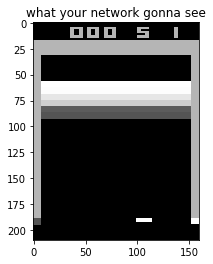

In [7]:
sess = tf.Session(graph= tf.get_default_graph())
RESET = 1
display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make("BreakoutDeterministic-v4")
obs = env.reset()
plt.title("what your network gonna see")
plt.imshow(obs[:,:,0], interpolation='none', cmap='gray')



Observation shape: (64, 64, 4)
Num actions: 4
shape (None, 1, 256)
shape (None, 1, 256)
 current_qvalues Tensor("functional_1/dense_1/BiasAdd:0", shape=(None, 4), dtype=float32)
 current_action_qvalues Tensor("Sum:0", shape=(None,), dtype=float32)
 state_values_target Tensor("Max:0", shape=(None,), dtype=float32)
 next_qvalues_target Tensor("functional_3/dense_3/BiasAdd:0", shape=(None, 4), dtype=float32)
 next_state_values_target Tensor("Max_1:0", shape=(None,), dtype=float32)
 target Tensor("add:0", shape=(None,), dtype=float32)
 td_loss Tensor("Mean:0", shape=(), dtype=float32)


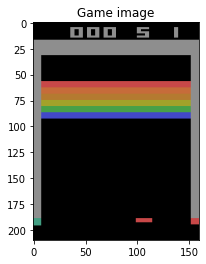

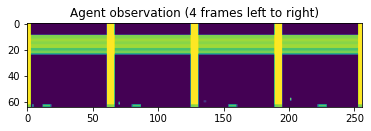

In [8]:
env = gym.make("BreakoutDeterministic-v4")
env = PreprocessAtari(env)
env = FrameBuffer(env, n_frames=4)
breakoutDQN = Breakout(sess,env)
env.reset()

plt.figure()
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
for _ in range(50):
  obs, _, _, _ = env.step(env.action_space.sample())

plt.figure()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))


In [9]:


if (RESET == 1):
  # ************ RESET everything **************************
  sess.run(tf.global_variables_initializer())
  saver = tf.train.Saver()
  
else:
  # ************ LOAD everything **************************
  epsilon = 0.01 
  saver = tf.train.Saver()
  saver.restore(sess, tf.train.latest_checkpoint('/content/drive/My Drive/Colab Notebooks/RL/Breakout/'))
  f=open(breakoutDQN.filepath,'r')
  for line in f:
    breakoutDQN.rewards_history.append(float(line.split()[0]))
    breakoutDQN.target_history.append(float(line.split()[3]))
    breakoutDQN.v_history.append(float(line.split()[4]))
    breakoutDQN.Loss_history.append(float(line.split()[6]))
  f.close()
  breakoutDQN.plots()

# Validate
rewards = breakoutDQN.evaluate(n_games=1)
print(rewards)

breakoutDQN.load_weigths_into_target_network()
s = env.framebuffer

for j in range(10000):
  agent_outputs = breakoutDQN.agent.get_qvalues([s])
  a = breakoutDQN.agent.sample_actions(agent_outputs,0)
  s_, r, done, _ = env.step(a)
  breakoutDQN.memory.append([s,a,s_,r,done])
  if done: 
      s = env.reset() 
  else:
      s = s_

[0.0]


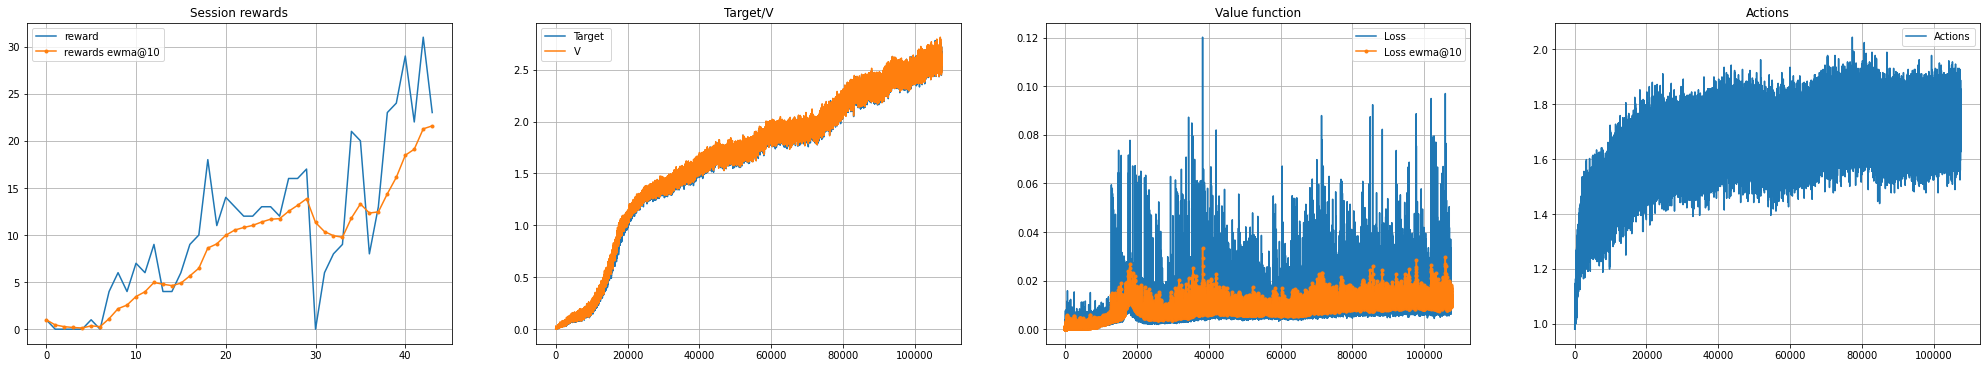

buffer size = 100000, epsilon = 0.11408


 54%|█████▍    | 107501/200000 [1:43:31<1:29:04, 17.31it/s]  

Good


In [10]:
f=open(breakoutDQN.filepath, "w")
epsilon = 1
with tqdm.trange(len(breakoutDQN.Loss_history), breakoutDQN.Training) as t:
  for i in t:
    s = env.framebuffer
    for j in range(10):
      agent_outputs = breakoutDQN.agent.get_qvalues([s])
      a = breakoutDQN.agent.sample_actions(agent_outputs,epsilon)
      s_, r, done, _ = env.step(a)
      breakoutDQN.memory.append([s,a,s_,r,done])
      if done: 
        s = env.reset() 
      else:
        s = s_
      
    breakoutDQN.train()

    if (np.mean(breakoutDQN.rewards_history[-10:]) > 20):
      print("Good")
      break
    
    if i % 500 == 0:
      
      breakoutDQN.load_weigths_into_target_network()
      epsilon = max(epsilon * 0.99, 0.01)
      if i % 2500 == 0:
        breakoutDQN.rewards_history.append(np.mean(breakoutDQN.evaluate(n_games=3)))
        breakoutDQN.plots()
        print("buffer size = %i, epsilon = %.5f" % (len(breakoutDQN.memory), epsilon))
      saver.save(sess, "/content/drive/My Drive/Colab Notebooks/RL/Breakout/model.h5")
      if i %10000 ==0:
        f.close()
        f=open(breakoutDQN.filepath, "a+")
      

      

f.close()

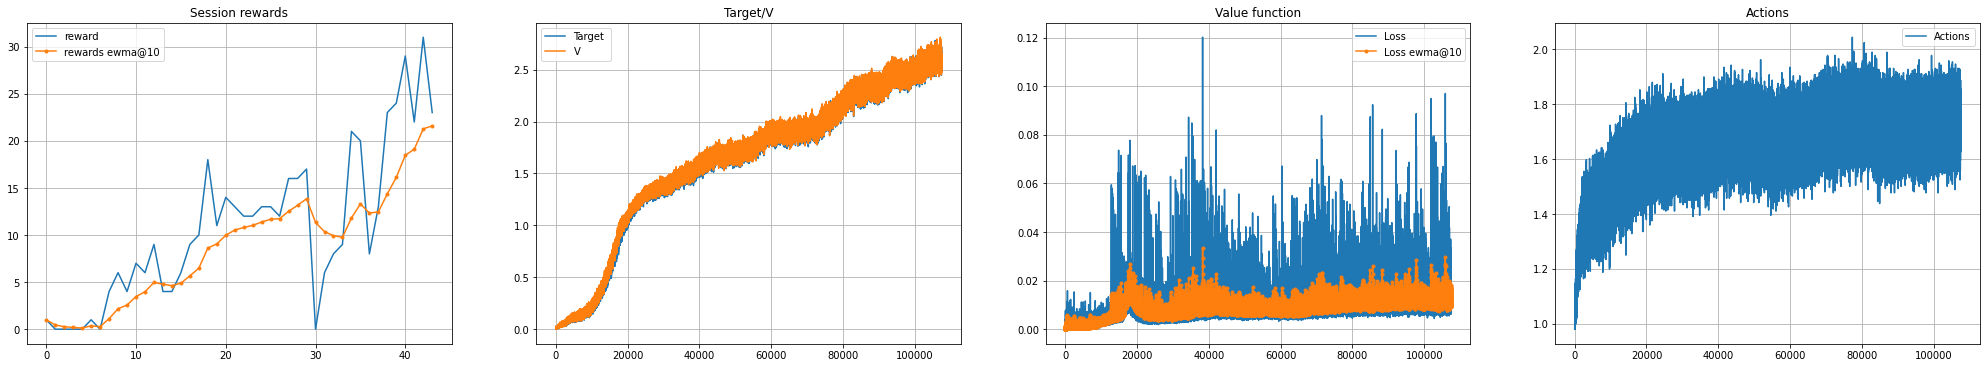

In [11]:
saver.save(sess, "/content/drive/My Drive/Colab Notebooks/RL/Breakout/model.h5")
breakoutDQN.plots()


In [12]:
display = Display(visible=0, size=(400, 300))
display.start()

def evaluate2(agent, env2, n_games=1, t_max= 10000):
  """Plays an a game from start till done, returns per-game rewards """
  game_rewards = []
  state = env2.reset()
  for x in range(n_games):
      total_reward = 0
      print("Cicle : ",x)
      for _ in range(t_max):
          action = breakoutDQN.agent.sample_actions(breakoutDQN.agent.get_qvalues([state]),0)
          state, reward, done, info = env2.step(action)
          total_reward += reward
          if done:
            state = env2.reset()
            break

      game_rewards.append(total_reward)
  return game_rewards

env2 = gym.make("BreakoutDeterministic-v4")
env2 = PreprocessAtari(env2)
env2 = FrameBuffer(env2, n_frames=4)
env_monitor = gym.wrappers.Monitor(env2, directory="/content/drive/My Drive/Colab Notebooks/RL/Breakout/videos", force=True)
final_rewards = evaluate2(breakoutDQN.agent, env_monitor, n_games=3)
env_monitor.close()

print("Final mean reward:", np.mean(final_rewards))

Cicle :  0
Cicle :  1
Cicle :  2
Final mean reward: 20.0
